# Intoduction

After much searching, it was determined that the salary information appears to be for the 2018 season. 2017 variables will be included to see if it predicts coach salary.

# Data

https://www.collegegridirons.com/comparisons-by-capacity/
Stadium Size Data

https://www.sports-reference.com/cfb/years/2017-team-offense.html 
detailed offense information

https://www.sports-reference.com/cfb/leaders/wins-post-coach-career.html bowl wins

https://www.sports-reference.com/cfb/leaders/wins-coach-career.html coach wins

https://sports.usatoday.com/ncaa/finances school finances

https://www.coacheshotseat.com/WinningestActiveCoachesIA.htm coaches data records

https://web3.ncaa.org/aprsearch/gsrsearch Graduation data

https://github.com/2SUBDA/IST_718 Original data file


# Reading Cleaning & Combining

In [1]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import pandas as pd #dataframe operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splitting
import statsmodels.api as sm #statistical models including regression
import statsmodels.formula.api as sfm #R-like model specification
import matplotlib.pyplot as plt #2D plotting
import seaborn as sns #Provides Trellis and small multiple plotting
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
#Bring in our data set
from google.colab import files
uploaded = files.upload()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving Coaches9.csv to Coaches9.csv


# Base Coaches Dataframe

In [3]:
import io
coaches = pd.read_csv(io.BytesIO(uploaded['Coaches9.csv']))
print(pd.DataFrame.head(coaches))

                  School Conference  ... AssistantPay        Buyout
0              Air Force   Mt. West  ...          $0             --
1                  Akron        MAC  ...          $0      $688,500 
2                Alabama        SEC  ...          $0   $33,600,000 
3  Alabama at Birmingham      C-USA  ...          $0    $3,847,500 
4      Appalachian State   Sun Belt  ...          $0    $2,160,417 

[5 rows x 9 columns]


In [4]:
coaches.describe()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
count,129,129,129,129,129,129,129,129,129
unique,129,11,129,104,105,85,51,1,102
top,Alabama at Birmingham,C-USA,David Beaty,"$3,500,000","$3,500,000",--,--,$0,--
freq,1,14,1,5,5,22,41,129,22


In [5]:
coaches.isnull().sum()

School          0
Conference      0
Coach           0
SchoolPay       0
TotalPay        0
Bonus           0
BonusPaid       0
AssistantPay    0
Buyout          0
dtype: int64

In [6]:
# Define numeric columns 
numColumns = ['SchoolPay', 'TotalPay', 'Bonus', 'BonusPaid', 'AssistantPay', 'Buyout']

# Replace dirty data $$$$ 
for i in numColumns:
    coaches[i] = coaches[i].replace('[$,]', '', regex=True)
    coaches[i] = coaches[i].replace('[--]', '0', regex=True)
    coaches[i] = coaches[i].astype(float)
     
coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0
1,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0
2,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0


In [7]:
# We dont care about assistant pay as it is a meaningless 0 variation coulmn 
del coaches['AssistantPay']
coaches.describe()

,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout
count,1.290000e+02,1.290000e+02,1.290000e+02,1.290000e+02,1.290000e+02
mean,2.335563e+06,2.342113e+06,7.250935e+05,1.020011e+05,6.734453e+06
std,1.898654e+06,1.903114e+06,6.652423e+05,2.088806e+05,1.000138e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.625700e+05,7.625700e+05,2.200000e+05,0.000000e+00,5.223000e+05
50%,1.800000e+06,1.830000e+06,6.250000e+05,2.000000e+04,2.671875e+06
75%,3.550000e+06,3.550000e+06,1.025000e+06,1.000000e+05,9.000000e+06
max,8.307000e+06,8.307000e+06,3.100000e+06,1.350000e+06,6.812500e+07


In [8]:
# Here we decide to just focus on School Pay
# To avoid temptation, all other numeric variables are removed 
coaches = coaches[["TotalPay","Conference","Coach","School"]]
coaches.head()

,TotalPay,Conference,Coach,School
0,885000.0,Mt. West,Troy Calhoun,Air Force
1,412500.0,MAC,Terry Bowden,Akron
2,8307000.0,SEC,Nick Saban,Alabama
3,900000.0,C-USA,Bill Clark,Alabama at Birmingham
4,712500.0,Sun Belt,Scott Satterfield,Appalachian State


# Coach Bowl Wins

In [9]:
uploaded2 = files.upload()
coaches_bowl = pd.read_csv(io.BytesIO(uploaded2['bowl wins.csv']))
print(pd.DataFrame.head(coaches_bowl))

Saving bowl wins.csv to bowl wins.csv
          Coach   W                           University
0   Joe Paterno  24                           Penn State
1  Bobby Bowden  22          Florida State West Virginia
2    Nick Saban  17    Alabama LSU Michigan State Toledo
3   Bear Bryant  15  Alabama Kentucky Maryland Texas A&M
4    Mack Brown  14          North Carolina Texas Tulane


In [10]:
# Build the fuzzy matcher
coaches_bowl['CoachFuzz'] = coaches_bowl.Coach.apply(lambda x: [process.extract(x, coaches.Coach, limit=1)][0][0][0])
coaches['CoachFuzz'] = coaches.Coach.apply(lambda x: [process.extract(x, coaches_bowl.Coach, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['Coach', 'Coach']
right_on = ['Coach', 'Coach']

# Merge the two data frames.
df_coach_bowl = pd.merge(coaches, coaches_bowl, how='left', left_on=left_on, right_on=right_on)
#df_coach_record[df_coach_record.W.isnull()]

In [11]:
df_coach_bowl['Bowl W'] = df_coach_bowl['W'].fillna(0)

In [12]:
df_coach_bowl=df_coach_bowl[["TotalPay","Conference","School","Coach","Bowl W"]]
df_coach_bowl.head()

,TotalPay,Conference,School,Coach,Bowl W
0,885000.0,Mt. West,Air Force,Troy Calhoun,5.0
1,412500.0,MAC,Akron,Terry Bowden,3.0
2,8307000.0,SEC,Alabama,Nick Saban,17.0
3,900000.0,C-USA,Alabama at Birmingham,Bill Clark,0.0
4,712500.0,Sun Belt,Appalachian State,Scott Satterfield,4.0


# Coach Career Records

In [13]:
uploaded3 = files.upload()

Saving coach wins career.csv to coach wins career.csv


In [14]:
coaches_career = pd.read_csv(io.BytesIO(uploaded3['coach wins career.csv']))
print(pd.DataFrame.head(coaches_career))

  Rank            Coach        School  ...  School W School L School Win %
0    1         Ryan Day    Ohio State  ...        21        1        0.955
1    2     Kalen DeBoer  Fresno State  ...         3        2        0.600
2    3    Lincoln Riley      Oklahoma  ...        43        8        0.843
3    4     Dabo Swinney       Clemson  ...       139       32        0.813
4    5  Eliah Drinkwitz      Missouri  ...         5        3        0.625

[5 rows x 14 columns]


In [15]:
# Build the fuzzy matcher
coaches_career['CoachFuzz'] = coaches_career.Coach.apply(lambda x: [process.extract(x, df_coach_bowl.Coach, limit=1)][0][0][0])
df_coach_bowl['CoachFuzz'] = df_coach_bowl.Coach.apply(lambda x: [process.extract(x, coaches_career.Coach, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['Coach', 'Coach']
right_on = ['Coach', 'Coach']

# Merge the two data frames.
df_2 = pd.merge(df_coach_bowl, coaches_career, how='left', left_on=left_on, right_on=right_on)
df_2.head()
#df_coach_record[df_coach_record.W.isnull()]

,TotalPay,Conference,School_x,Coach,Bowl W,CoachFuzz_x,Rank,School_y,Age,Conf.,Compensation,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,CoachFuzz_y
0,885000.0,Mt. West,Air Force,Troy Calhoun,5.0,Troy Calhoun,66,Air Force,54,MWC,"$2,000,000",14,101,71,0.587000,14,101,71,0.587000,Troy Calhoun
1,412500.0,MAC,Akron,Terry Bowden,3.0,Terry Bowden,131,Akron,65,x,x,48,175,114,0.605536,6,35,52,0.402299,Terry Bowden
2,8307000.0,SEC,Alabama,Nick Saban,17.0,Nick Saban,7,Alabama,69,SEC,"$12,000,000",25,257,65,0.797000,14,166,23,0.878000,Nick Saban
3,900000.0,C-USA,Alabama at Birmingham,Bill Clark,0.0,Bill Clark,36,UAB,52,CUSA,"$1,500,000",6,49,26,0.653000,5,38,22,0.633000,Bill Clark
4,712500.0,Sun Belt,Appalachian State,Scott Satterfield,4.0,Scott Satterfield,46,Louisville,48,ACC,"$4,000,000",8,61,36,0.629000,2,10,12,0.455000,Scott Satterfield


In [16]:
df_coach_final=df_2[["TotalPay","Conference","Coach","Bowl W","School_x","Age","Career Yrs.","Career W","Career L", "Career Win %", "School Yrs.", "School W", "School L", "School Win %"]]
df_coach_final = df_coach_final.rename(columns={'School_x': 'School'})
df_coach_final.head()

,TotalPay,Conference,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299
2,8307000.0,SEC,Nick Saban,17.0,Alabama,69,25,257,65,0.797000,14,166,23,0.878000
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000


In [17]:
df_coach_final.isnull().sum()

TotalPay        0
Conference      0
Coach           0
Bowl W          0
School          0
Age             0
Career Yrs.     0
Career W        0
Career L        0
Career Win %    0
School Yrs.     0
School W        0
School L        0
School Win %    0
dtype: int64

# Program Revenue

In [18]:
uploaded4 = files.upload()

Saving program revenue.csv to program revenue.csv


In [19]:
program_revenue = pd.read_csv(io.BytesIO(uploaded4['program revenue.csv']))
print(pd.DataFrame.head(program_revenue))

    RK      SCHOOL     CONF  ... TOTAL EXPENSES TOTAL ALLOCATED % ALLOCATED
0  1.0       Texas   Big 12  ...  $204,234,897              $0         0.00
1  2.0   Texas A&M      SEC  ...  $169,012,456              $0         0.00
2  3.0  Ohio State  Big Ten  ...  $220,572,956              $0         0.00
3  4.0    Michigan  Big Ten  ...  $190,952,175        $261,773         0.13
4  5.0     Georgia      SEC  ...  $143,299,554      $3,508,850         2.02

[5 rows x 7 columns]


In [20]:
# Build the fuzzy matcher
program_revenue['SchoolFuzz'] = program_revenue.SCHOOL.apply(lambda x: [process.extract(x, df_coach_final.School, limit=1)][0][0][0])
df_coach_final['SchoolFuzz'] = df_coach_final.School.apply(lambda x: [process.extract(x, program_revenue.SCHOOL, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['School', 'SchoolFuzz']
right_on = ['SCHOOL', 'SchoolFuzz']

# Merge the two data frames.
df_coach_revenue = pd.merge(df_coach_final, program_revenue, how='left', left_on=left_on, right_on=right_on)

In [21]:
# Remove commas from Capacity variable and convert to numeric
df_coach_revenue['Program Revenue'] = df_coach_revenue['TOTAL REVENUE'].replace(',', '', regex=True).astype(float)

df_coach_revenue.drop(columns=['RK', 'SCHOOL','CONF',"TOTAL EXPENSES","TOTAL ALLOCATED","% ALLOCATED","SchoolFuzz","TOTAL REVENUE"],inplace=True,axis=1)
df_coach_revenue.head()

,TotalPay,Conference,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Program Revenue
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,60009782.0
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,37194485.0
2,8307000.0,SEC,Nick Saban,17.0,Alabama,69,25,257,65,0.797000,14,166,23,0.878000,164090889.0
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,36494381.0
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,37996512.0


# Stadium Seating

In [22]:
uploaded5 = files.upload()

Saving stadiums.csv to stadiums.csv


In [23]:
stadiums = pd.read_csv(io.BytesIO(uploaded5['stadiums.csv']))
print(pd.DataFrame.head(stadiums))

            Stadium     College Conference Capacity  Opened
0  Michigan Stadium    Michigan    Big Ten  107,601  1927.0
1    Beaver Stadium  Penn State    Big Ten  106,572  1960.0
2      Ohio Stadium  Ohio State    Big Ten  104,944  1922.0
3        Kyle Field   Texas A&M        SEC  102,733  1904.0
4   Neyland Stadium   Tennessee        SEC  102,521  1921.0


In [24]:
# Remove commas from Capacity variable and convert to numeric
stadiums['Capacity'] = stadiums['Capacity'].replace(',', '', regex=True).astype(float)
stadiums.head()

,Stadium,College,Conference,Capacity,Opened
0,Michigan Stadium,Michigan,Big Ten,107601.0,1927.0
1,Beaver Stadium,Penn State,Big Ten,106572.0,1960.0
2,Ohio Stadium,Ohio State,Big Ten,104944.0,1922.0
3,Kyle Field,Texas A&M,SEC,102733.0,1904.0
4,Neyland Stadium,Tennessee,SEC,102521.0,1921.0


In [25]:
# Build the fuzzy matcher
stadiums['SchoolFuzz'] = stadiums.College.apply(lambda x: [process.extract(x, df_coach_revenue.School, limit=1)][0][0][0])
df_coach_revenue['SchoolFuzz'] = df_coach_revenue.School.apply(lambda x: [process.extract(x, stadiums.College, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['School', 'SchoolFuzz']
right_on = ['College', 'SchoolFuzz']

# Merge the two data frames.
df_3 = pd.merge(df_coach_final, stadiums, how='left', left_on=left_on, right_on=right_on)

In [26]:
df_3.drop(columns=['SchoolFuzz', 'Stadium','College',"Conference_y","Opened"],inplace=True,axis=1)
df_3.head()

,TotalPay,Conference_x,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0
2,8307000.0,SEC,Nick Saban,17.0,Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0


In [27]:
print(df_3.isnull().sum())
print(len(df_3))

TotalPay        0
Conference_x    0
Coach           0
Bowl W          0
School          0
Age             0
Career Yrs.     0
Career W        0
Career L        0
Career Win %    0
School Yrs.     0
School W        0
School L        0
School Win %    0
Capacity        0
dtype: int64
129


In [28]:
# Build the fuzzy matcher
df_coach_revenue["School2"]=df_coach_revenue["School"]
df_coach_revenue.drop(columns=['TotalPay', 'Conference','Bowl W',"Age","Career Yrs.","Career W","Career Win %","School","Coach","Career L","School Yrs.","School W","School L","School Win %"],inplace=True,axis=1)
df_coach_revenue['SchoolFuzz'] = df_coach_revenue.School2.apply(lambda x: [process.extract(x, df_3.School, limit=1)][0][0][0])
df_3['SchoolFuzz'] = df_3.School.apply(lambda x: [process.extract(x, df_coach_revenue.School2, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['School', 'SchoolFuzz']
right_on = ['School2', 'SchoolFuzz']

# Merge the two data frames.
df_aa = pd.merge(df_3, df_coach_revenue, how='left', left_on=left_on, right_on=right_on)
df_aa.drop(columns=['SchoolFuzz', 'School2'],inplace=True,axis=1)

In [29]:
df_3= df_aa
df_3.head()

,TotalPay,Conference_x,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0,60009782.0
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0,37194485.0
2,8307000.0,SEC,Nick Saban,17.0,Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0,164090889.0
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0,37996512.0


# Team AP Ratings

In [30]:
uploaded6 = files.upload()

Saving team ratings.csv to team ratings.csv


In [31]:
team = pd.read_csv(io.BytesIO(uploaded6['team ratings.csv']))
print(pd.DataFrame.head(team))

   Rk                School            Conf  ...  AP Pre  AP High  AP Rank
0   1               Clemson  ACC (Atlantic)  ...     5.0      1.0      4.0
1   2  North Carolina State  ACC (Atlantic)  ...     NaN     14.0     23.0
2   3            Louisville  ACC (Atlantic)  ...    16.0     14.0      NaN
3   4           Wake Forest  ACC (Atlantic)  ...     NaN      NaN      NaN
4   5        Boston College  ACC (Atlantic)  ...     NaN      NaN      NaN

[5 rows x 16 columns]


In [32]:
# Build the fuzzy matcher
team['SchoolFuzz'] = team.School.apply(lambda x: [process.extract(x, df_3.School, limit=1)][0][0][0])
df_3['SchoolFuzz'] = df_3.School.apply(lambda x: [process.extract(x, team.School, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['School', 'SchoolFuzz']
right_on = ['School', 'SchoolFuzz']

# Merge the two data frames.
df_4 = pd.merge(df_3, team, how='left', left_on=left_on, right_on=right_on)

In [33]:
df_4.drop(columns=['SchoolFuzz', 'Conf','Rk'],inplace=True,axis=1)
df_4.head()

,TotalPay,Conference_x,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0,60009782.0,5.0,7.0,0.417,4.0,4.0,0.500,31.4,32.4,-4.77,-1.02,NaN,NaN,NaN
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0,37194485.0,7.0,7.0,0.500,6.0,2.0,0.750,22.1,28.0,-4.82,-1.96,NaN,NaN,NaN
2,8307000.0,SEC,Nick Saban,17.0,Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0,164090889.0,13.0,1.0,0.929,7.0,1.0,0.875,37.1,11.9,21.25,5.46,1.0,1.0,1.0
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0,37996512.0,9.0,4.0,0.692,7.0,1.0,0.875,33.5,20.2,0.59,-7.72,NaN,NaN,NaN


In [34]:
df_4['AP Pre'] = df_4['AP Pre'].fillna(50)
df_4['AP High'] = df_4['AP High'].fillna(50)
df_4['AP Rank'] = df_4['AP Rank'].fillna(50)
df_4.head()

,TotalPay,Conference_x,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0,60009782.0,5.0,7.0,0.417,4.0,4.0,0.500,31.4,32.4,-4.77,-1.02,50.0,50.0,50.0
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0,37194485.0,7.0,7.0,0.500,6.0,2.0,0.750,22.1,28.0,-4.82,-1.96,50.0,50.0,50.0
2,8307000.0,SEC,Nick Saban,17.0,Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0,164090889.0,13.0,1.0,0.929,7.0,1.0,0.875,37.1,11.9,21.25,5.46,1.0,1.0,1.0
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0,37996512.0,9.0,4.0,0.692,7.0,1.0,0.875,33.5,20.2,0.59,-7.72,50.0,50.0,50.0


# Team Detailed Stats

In [35]:
uploaded7 = files.upload()

Saving team detailed stats.csv to team detailed stats.csv


In [36]:
team2 = pd.read_csv(io.BytesIO(uploaded7['team detailed stats.csv']))
print(pd.DataFrame.head(team2))

   Rk          School   G  ...  TurnoversFum  TurnoversInt  TurnoversTot
0   1             UCF  13  ...           0.5           0.7           1.2
1   2         Memphis  13  ...           0.5           0.8           1.2
2   3        Oklahoma  14  ...           0.5           0.4           0.9
3   4  Oklahoma State  13  ...           0.8           0.8           1.6
4   5         Arizona  13  ...           0.7           1.0           1.7

[5 rows x 25 columns]


In [37]:
# Build the fuzzy matcher
team2['SchoolFuzz'] = team2.School.apply(lambda x: [process.extract(x, df_4.School, limit=1)][0][0][0])
df_4['SchoolFuzz'] = df_4.School.apply(lambda x: [process.extract(x, team2.School, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['School', 'SchoolFuzz']
right_on = ['School', 'SchoolFuzz']

# Merge the two data frames.
df_5 = pd.merge(df_4, team2, how='left', left_on=left_on, right_on=right_on)

In [38]:
df_5.drop(columns=['SchoolFuzz', 'G','Rk'],inplace=True,axis=1)
df_5 = df_5.rename(columns={'Conference_x': 'Conference'})
print(len(df_5))
df_5.head()

129


,TotalPay,Conference,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank,Pts,Passing Cmp,PassingAtt,PassingPct,PassingYds,PassingTD,RushingAtt,RushingYds,RushingAvg,RushingTD,Total OffensePlays,Total OffenseYds,Total OffenseAvg,First DownsPass,First DownsRush,First DownsPen,First DownsTot,PenaltiesNo.,PenaltiesYds,TurnoversFum,TurnoversInt,TurnoversTot
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0,60009782.0,5.0,7.0,0.417,4.0,4.0,0.500,31.4,32.4,-4.77,-1.02,50.0,50.0,50.0,31.4,5.8,11.9,48.3,110.1,0.8,63.6,306.3,4.8,3.2,75.5,416.3,5.5,4.3,18.3,1.6,24.2,4.0,38.8,1.2,0.5,1.7
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0,37194485.0,7.0,7.0,0.500,6.0,2.0,0.750,22.1,28.0,-4.82,-1.96,50.0,50.0,50.0,22.1,17.3,31.9,54.1,210.6,1.7,32.8,105.7,3.2,1.0,64.7,316.4,4.9,9.8,6.4,2.2,18.4,6.3,62.4,0.4,0.8,1.2
2,8307000.0,SEC,Nick Saban,17.0,Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0,164090889.0,13.0,1.0,0.929,7.0,1.0,0.875,37.1,11.9,21.25,5.46,1.0,1.0,1.0,37.1,14.6,23.8,61.3,193.4,2.0,43.7,250.6,5.7,2.6,67.5,444.1,6.6,8.6,12.4,1.4,22.2,4.9,40.6,0.5,0.2,0.7
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0,37996512.0,9.0,4.0,0.692,7.0,1.0,0.875,33.5,20.2,0.59,-7.72,50.0,50.0,50.0,33.5,16.5,27.4,60.4,216.2,2.2,40.8,223.6,5.5,2.1,68.2,439.8,6.5,8.8,10.5,1.6,20.9,7.0,63.9,0.6,0.5,1.1


# Graduation Rates

In [39]:
uploaded8 = files.upload()

Saving graduation.csv to graduation.csv


In [40]:
grad = pd.read_csv(io.BytesIO(uploaded8['graduation.csv']))
print(pd.DataFrame.head(grad))

   Cohort Year                        School  ...   GSR   FGR
0         2013  Abilene Christian University  ...  74.0  53.0
1         2013           University of Akron  ...  78.0  67.0
2         2013        Alabama A&M University  ...  58.0  48.0
3         2013      Alabama State University  ...  67.0  41.0
4         2013         University of Alabama  ...  88.0  63.0

[5 rows x 7 columns]


In [41]:
# Cleaning Graduation Rate data set. 

# Rename Conferences.
grOrgName = ['Southland Conference', 'Mid-American Conference', 'Southwestern Athletic Conf.', 'Southeastern Conference', 'Conference USA',
             'Colonial Athletic Association', 'Sun Belt Conference', 'Pac-12 Conference', 'Ohio Valley Conference', 'Big South Conference',
             'Big 12 Conference', 'Mid-Eastern Athletic Conf.', 'Mountain West Conference', 'Atlantic Coast Conference', 'Independent', 
             'The Ivy League', 'Northeast Conference', 'Patriot League', 'Pioneer Football League', 'Big Sky Conference', 
             'American Athletic Conference', 'Southern Conference', 'Missouri Valley Football Conference', 'Big Ten Conference']

grNewName = ['SLC', 'MAC', 'SWAC', 'SEC', 'C-USA', 'CAA', 'Sun Belt', 'Pac-12', 'OVC', 'Big South', 'Big 12', 'MEAC', 'Mt. West', 'ACC', 'Ind.', 
            'Ivy', 'NEC', 'Patriot League', 'PFL', 'Big Sky', 'AAC', 'SoCon', 'MVFC', 'Big Ten']

grad['Conference'] = grad['Conference'].replace(grOrgName, grNewName, regex=False)

# Check final result to see that everything is correct. 
grad.head()

,Cohort Year,School,Conference,Sport,State,GSR,FGR
0,2013,Abilene Christian University,SLC,Football,TX,74.0,53.0
1,2013,University of Akron,MAC,Football,OH,78.0,67.0
2,2013,Alabama A&M University,SWAC,Football,AL,58.0,48.0
3,2013,Alabama State University,SWAC,Football,AL,67.0,41.0
4,2013,University of Alabama,SEC,Football,AL,88.0,63.0


In [42]:
# Additional cleaning needed to be done in order to get a full match with fuzzywuzzy. 
# Original names in df_coach_record data set.
oldSchool = ['Connecticut', 'Georgia Tech', 'Miami (Fla.)', 'Virginia', 'Virginia Tech', 'Kansas', 'Kansas State', 'Texas', 
            'Illinois', 'Indiana', 'Iowa', 'Michigan', 'Northwestern', 'Penn State', 'Rutgers', 'Texas-San Antonio', 
            'Fresno State', 'New Mexico', 'California', 'Colorado', 'UCLA', 'Utah', 'Washington', 'Alabama', 'Arkansas', 'Florida', 
            'Georgia', 'Kentucky', 'LSU', 'South Carolina', 'Tennessee', 'Louisiana-Monroe']

# School names as they appear on graduation_rate data set. 
newSchool = ['University of Connecticut', 'Georgia Institute of Technology', 'University of Miami (Florida)', 'University of Virginia', 
            'Virginia Polytechnic Institute and State University', 'University of Kansas', 'Kansas State University', 
            'University of Texas at Austin', 'University of Illinois Urbana-Champaign', 'Indiana University, Bloomington', 
            'University of Iowa', 'University of Michigan', 'Northwestern University', 'Pennsylvania State University', 
            'Rutgers, The State University of New Jersey, New Brunswick', 'University of Texas at San Antonio', 
            'California State University, Fresno', 'University of New Mexico', 'University of California, Berkeley', 
            'University of Colorado, Boulder', 'University of California, Los Angeles', 'University of Utah', 'University of Washington', 
            'University of Alabama', 'University of Arkansas, Fayetteville', 'University of Florida', 'University of Georgia', 
            'University of Kentucky', 'Louisiana State University', 'University of South Carolina, Columbia', 
            'University of Tennessee, Knoxville', 'University of Louisiana at Monroe']

# Replaces old names with new names so data sets match one-on-one
df_5['School'] = df_5['School'].replace(oldSchool, newSchool, regex=False)

In [43]:
# Build the fuzzy matcher
df_5['SchoolFuzz'] = df_5.School.apply(lambda x: [process.extract(x, grad.School, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['Conference', 'SchoolFuzz']
right_on = ['Conference', 'School']

# Merge the two data frames.
df_6 = pd.merge(df_5, grad, how='left', left_on=left_on, right_on=right_on)
df_6.head()

,TotalPay,Conference,Coach,Bowl W,School_x,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank,Pts,Passing Cmp,PassingAtt,PassingPct,PassingYds,PassingTD,RushingAtt,RushingYds,RushingAvg,RushingTD,Total OffensePlays,Total OffenseYds,Total OffenseAvg,First DownsPass,First DownsRush,First DownsPen,First DownsTot,PenaltiesNo.,PenaltiesYds,TurnoversFum,TurnoversInt,TurnoversTot,SchoolFuzz,Cohort Year,School_y,Sport,State,GSR,FGR
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0,60009782.0,5.0,7.0,0.417,4.0,4.0,0.500,31.4,32.4,-4.77,-1.02,50.0,50.0,50.0,31.4,5.8,11.9,48.3,110.1,0.8,63.6,306.3,4.8,3.2,75.5,416.3,5.5,4.3,18.3,1.6,24.2,4.0,38.8,1.2,0.5,1.7,U.S. Air Force Academy,2013.0,U.S. Air Force Academy,Football,CO,87.0,NaN
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0,37194485.0,7.0,7.0,0.500,6.0,2.0,0.750,22.1,28.0,-4.82,-1.96,50.0,50.0,50.0,22.1,17.3,31.9,54.1,210.6,1.7,32.8,105.7,3.2,1.0,64.7,316.4,4.9,9.8,6.4,2.2,18.4,6.3,62.4,0.4,0.8,1.2,University of Akron,2013.0,University of Akron,Football,OH,78.0,67.0
2,8307000.0,SEC,Nick Saban,17.0,University of Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0,164090889.0,13.0,1.0,0.929,7.0,1.0,0.875,37.1,11.9,21.25,5.46,1.0,1.0,1.0,37.1,14.6,23.8,61.3,193.4,2.0,43.7,250.6,5.7,2.6,67.5,444.1,6.6,8.6,12.4,1.4,22.2,4.9,40.6,0.5,0.2,0.7,University of Alabama,2013.0,University of Alabama,Football,AL,88.0,63.0
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,University of Alabama at Birmingham,2013.0,University of Alabama at Birmingham,Football,AL,73.0,47.0
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0,37996512.0,9.0,4.0,0.692,7.0,1.0,0.875,33.5,20.2,0.59,-7.72,50.0,50.0,50.0,33.5,16.5,27.4,60.4,216.2,2.2,40.8,223.6,5.5,2.1,68.2,439.8,6.5,8.8,10.5,1.6,20.9,7.0,63.9,0.6,0.5,1.1,Appalachian State University,2013.0,Appalachian State University,Football,NC,77.0,65.0


In [44]:
df_6.drop(columns=['SchoolFuzz', 'Cohort Year','Sport','School_y'],inplace=True,axis=1)
print(len(df_6))


129


In [45]:
df_6.rename(columns={'School_x': 'School'},inplace=True)
df_6.head()

,TotalPay,Conference,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank,Pts,Passing Cmp,PassingAtt,PassingPct,PassingYds,PassingTD,RushingAtt,RushingYds,RushingAvg,RushingTD,Total OffensePlays,Total OffenseYds,Total OffenseAvg,First DownsPass,First DownsRush,First DownsPen,First DownsTot,PenaltiesNo.,PenaltiesYds,TurnoversFum,TurnoversInt,TurnoversTot,State,GSR,FGR
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0,60009782.0,5.0,7.0,0.417,4.0,4.0,0.500,31.4,32.4,-4.77,-1.02,50.0,50.0,50.0,31.4,5.8,11.9,48.3,110.1,0.8,63.6,306.3,4.8,3.2,75.5,416.3,5.5,4.3,18.3,1.6,24.2,4.0,38.8,1.2,0.5,1.7,CO,87.0,NaN
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0,37194485.0,7.0,7.0,0.500,6.0,2.0,0.750,22.1,28.0,-4.82,-1.96,50.0,50.0,50.0,22.1,17.3,31.9,54.1,210.6,1.7,32.8,105.7,3.2,1.0,64.7,316.4,4.9,9.8,6.4,2.2,18.4,6.3,62.4,0.4,0.8,1.2,OH,78.0,67.0
2,8307000.0,SEC,Nick Saban,17.0,University of Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0,164090889.0,13.0,1.0,0.929,7.0,1.0,0.875,37.1,11.9,21.25,5.46,1.0,1.0,1.0,37.1,14.6,23.8,61.3,193.4,2.0,43.7,250.6,5.7,2.6,67.5,444.1,6.6,8.6,12.4,1.4,22.2,4.9,40.6,0.5,0.2,0.7,AL,88.0,63.0
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,73.0,47.0
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0,37996512.0,9.0,4.0,0.692,7.0,1.0,0.875,33.5,20.2,0.59,-7.72,50.0,50.0,50.0,33.5,16.5,27.4,60.4,216.2,2.2,40.8,223.6,5.5,2.1,68.2,439.8,6.5,8.8,10.5,1.6,20.9,7.0,63.9,0.6,0.5,1.1,NC,77.0,65.0


In [46]:
df_6['GSR'].fillna((df_6['GSR'].mean()), inplace=True)
df_6['FGR'].fillna((df_6['FGR'].mean()), inplace=True)

In [47]:
df_6[df_6.isnull().any(axis=1)]

,TotalPay,Conference,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank,Pts,Passing Cmp,PassingAtt,PassingPct,PassingYds,PassingTD,RushingAtt,RushingYds,RushingAvg,RushingTD,Total OffensePlays,Total OffenseYds,Total OffenseAvg,First DownsPass,First DownsRush,First DownsPen,First DownsTot,PenaltiesNo.,PenaltiesYds,TurnoversFum,TurnoversInt,TurnoversTot,State,GSR,FGR
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,73.000000,47.000
9,932521.0,Ind.,Jeff Monken,3.0,Army,53,11,85,54,0.612000,7,47,38,0.553000,38000.0,25000000.0,10.0,3.0,0.769,NaN,NaN,NaN,30.7,22.0,3.69,-3.00,50.0,50.0,50.0,30.7,1.5,5.0,30.8,27.8,0.2,60.4,362.3,6.0,3.8,65.4,390.1,6.0,1.2,18.5,1.0,20.8,4.2,36.3,0.4,0.5,0.8,NaN,80.181102,62.904
15,437228.0,MAC,Mike Jinks,0.0,Bowling Green,49,3,7,24,0.225806,3,7,24,0.225806,23724.0,26001184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OH,78.000000,68.000
16,0.0,Ind.,Kalani Sitake,3.0,Brigham Young,45,5,36,26,0.580000,5,36,26,0.580000,63725.0,23171603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,17.1,17.5,32.2,54.5,194.6,1.0,30.9,130.7,4.2,0.9,63.1,325.3,5.2,8.9,6.7,0.9,16.5,4.5,39.2,0.6,1.5,2.1,UT,70.000000,40.000
19,1700000.0,AAC,Josh Heupel,0.0,Central Florida,42,3,28,7,0.800000,3,28,7,0.800000,45323.0,69121887.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,81.000000,65.000
41,1750000.0,AAC,Major Applewhite,0.0,Houston,42,3,15,11,0.576923,3,15,11,0.576923,40000.0,75049955.0,7.0,5.0,0.583,5.0,3.0,0.625,28.3,23.8,2.63,-0.70,50.0,50.0,50.0,28.3,23.4,34.3,68.4,261.3,1.3,37.2,166.8,4.5,2.1,71.4,428.2,6.0,11.6,8.1,1.3,21.0,6.0,53.8,0.9,1.0,1.9,NaN,80.181102,62.904
50,947281.0,Ind.,Turner Gill,0.0,Liberty,58,12,72,84,0.461538,7,47,35,0.573171,25000.0,16358467.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VA,65.000000,55.000
52,850000.0,Sun Belt,Billy Napier,2.0,Louisiana-Lafayette,41,3,27,11,0.711000,3,27,11,0.711000,31000.0,32544966.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA,85.000000,68.000
58,500000.0,Ind.,Mark Whipple,0.0,Massachusetts,64,21,137,103,0.570833,11,65,70,0.481481,17000.0,49461013.0,4.0,8.0,0.333,NaN,NaN,NaN,30.6,31.8,-9.36,-7.03,50.0,50.0,50.0,30.6,22.7,37.3,60.9,297.5,2.2,34.8,135.5,3.9,1.6,72.1,433.0,6.0,12.8,6.8,2.0,21.7,6.6,56.6,0.9,0.5,1.4,MA,67.000000,51.000
60,4058061.0,ACC,Mark Richt,10.0,University of Miami (Florida),61,18,171,64,0.727660,3,26,13,0.666667,65326.0,30000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,76.000000,42.000


In [48]:
df_6.at[9, 'State'] = "NY"
df_6.at[41, 'State'] = "TX"

In [49]:
df_6.isnull().sum()

TotalPay               0
Conference             0
Coach                  0
Bowl W                 0
School                 0
Age                    0
Career Yrs.            0
Career W               0
Career L               0
Career Win %           0
School Yrs.            0
School W               0
School L               0
School Win %           0
Capacity               0
Program Revenue        0
Overall W             15
Overall L             15
Overall Pct           15
Conference W          17
Conference L          17
Conference Pct        18
PPG Off               15
PPG Def               15
SRS                   15
SOS                   15
AP Pre                 0
AP High                0
AP Rank                0
Pts                   15
Passing Cmp           15
PassingAtt            15
PassingPct            15
PassingYds            15
PassingTD             15
RushingAtt            15
RushingYds            15
RushingAvg            15
RushingTD             15
Total OffensePlays    15


# US MAP Plots

In [50]:
import requests
from bs4 import BeautifulSoup
import plotly.express as px

In [51]:
map_df = df_6[["TotalPay", "State"]]
map_df.head()

,TotalPay,State
0,885000.0,CO
1,412500.0,OH
2,8307000.0,AL
3,900000.0,AL
4,712500.0,NC


In [52]:
map_2=map_df.groupby("State").mean().reset_index()
#map_2 = pd.DataFrame(map_2, columns=['State', 'TotalPay'])
map_2.head()

,State,TotalPay
0,AL,3.464531e+06
1,AR,2.162500e+06
2,AZ,2.000000e+06
3,CA,2.107358e+06
4,CO,1.854500e+06


In [53]:
fig = px.choropleth(map_2,
                    locations='State',
                    color='TotalPay',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'TotalPay':'Coach Total Pay'},
                    title="Average Coach Pay by State",
                    scope='usa')
fig.update_layout(
    #title="Average Coach Pay by State",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.update_layout(
    title={
        'text': "Average Coach Pay by State",
        'y':0.9,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [54]:
map_max=map_df.groupby(['State'], sort=False)['TotalPay'].max().reset_index()
fig2 = px.choropleth(map_max,
                    locations='State',
                    color='TotalPay',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'TotalPay':'Max Coach Pay'},
                    title="Max Coach Pay by State",
                    scope='usa')
fig2.update_layout(
    #title="Average Coach Pay by State",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig2.update_layout(
    title={
        'text': "Max Coach Pay by State",
        'y':0.9,
        'x':0.46,
        'xanchor': 'center',
        'yanchor': 'top'})

fig2.show()

Feels good to coach in the deep South (SEC probably) and also some Big 10 lovin' in the midwest

# Develop a geographic visualization that in your view best depicts the conferences’ median salary

In [55]:
map_3=df_6.groupby(['Conference','State']).median().reset_index()
#map_2 = pd.DataFrame(map_2, columns=['State', 'TotalPay'])
conf_med= map_3[['Conference','State','TotalPay']]
conf_med

,Conference,State,TotalPay
0,AAC,CT,1100000.0
1,AAC,FL,1350000.0
2,AAC,LA,1629000.0
3,AAC,MD,2163000.0
4,AAC,NC,1102500.0
...,...,...,...
82,Sun Belt,GA,609500.0
83,Sun Belt,LA,620000.0
84,Sun Belt,NC,712500.0
85,Sun Belt,SC,400000.0


In [56]:
ACC =(conf_med.loc[conf_med['Conference'] == 'ACC'])
SEC =(conf_med.loc[conf_med['Conference'] == 'SEC'])

In [57]:
fig3 = px.choropleth(ACC,
                    locations='State',
                    color='TotalPay',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'TotalPay':'Median Coach Pay'},
                    title="Median ACC Coach Pay by State",
                    scope='usa')
fig3.update_layout(
    title={
        'text': "Median ACC Coach Pay by State",
        'y':0.9,
        'x':0.46,
        'xanchor': 'center',
        'yanchor': 'top'})

fig3.show()

In [58]:
fig4 = px.choropleth(SEC,
                    locations='State',
                    color='TotalPay',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'TotalPay':'Median Coach Pay'},
                    title="Median ACC Coach Pay by State",
                    scope='usa')
fig4.update_layout(
    title={
        'text': "Median SEC Coach Pay by State",
        'y':0.9,
        'x':0.46,
        'xanchor': 'center',
        'yanchor': 'top'})

fig4.show()

# Final Data Cleaning

In [59]:
#Drop it like it's hot
df_clean=df_6.dropna()
print(len(df_clean))
df_clean.head()

110


,TotalPay,Conference,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank,Pts,Passing Cmp,PassingAtt,PassingPct,PassingYds,PassingTD,RushingAtt,RushingYds,RushingAvg,RushingTD,Total OffensePlays,Total OffenseYds,Total OffenseAvg,First DownsPass,First DownsRush,First DownsPen,First DownsTot,PenaltiesNo.,PenaltiesYds,TurnoversFum,TurnoversInt,TurnoversTot,State,GSR,FGR
0,885000.0,Mt. West,Troy Calhoun,5.0,Air Force,54,14,101,71,0.587000,14,101,71,0.587000,52237.0,60009782.0,5.0,7.0,0.417,4.0,4.0,0.500,31.4,32.4,-4.77,-1.02,50.0,50.0,50.0,31.4,5.8,11.9,48.3,110.1,0.8,63.6,306.3,4.8,3.2,75.5,416.3,5.5,4.3,18.3,1.6,24.2,4.0,38.8,1.2,0.5,1.7,CO,87.0,62.904
1,412500.0,MAC,Terry Bowden,3.0,Akron,65,48,175,114,0.605536,6,35,52,0.402299,30000.0,37194485.0,7.0,7.0,0.500,6.0,2.0,0.750,22.1,28.0,-4.82,-1.96,50.0,50.0,50.0,22.1,17.3,31.9,54.1,210.6,1.7,32.8,105.7,3.2,1.0,64.7,316.4,4.9,9.8,6.4,2.2,18.4,6.3,62.4,0.4,0.8,1.2,OH,78.0,67.000
2,8307000.0,SEC,Nick Saban,17.0,University of Alabama,69,25,257,65,0.797000,14,166,23,0.878000,101821.0,164090889.0,13.0,1.0,0.929,7.0,1.0,0.875,37.1,11.9,21.25,5.46,1.0,1.0,1.0,37.1,14.6,23.8,61.3,193.4,2.0,43.7,250.6,5.7,2.6,67.5,444.1,6.6,8.6,12.4,1.4,22.2,4.9,40.6,0.5,0.2,0.7,AL,88.0,63.000
4,712500.0,Sun Belt,Scott Satterfield,4.0,Appalachian State,48,8,61,36,0.629000,2,10,12,0.455000,24150.0,37996512.0,9.0,4.0,0.692,7.0,1.0,0.875,33.5,20.2,0.59,-7.72,50.0,50.0,50.0,33.5,16.5,27.4,60.4,216.2,2.2,40.8,223.6,5.5,2.1,68.2,439.8,6.5,8.8,10.5,1.6,20.9,7.0,63.9,0.6,0.5,1.1,NC,77.0,65.000
5,2000000.0,Pac-12,Kevin Sumlin,4.0,Arizona,56,13,95,62,0.605000,3,9,19,0.321000,56037.0,105091389.0,7.0,6.0,0.538,5.0,4.0,0.556,41.3,34.4,3.17,-0.98,50.0,23.0,50.0,41.3,14.1,22.7,62.0,180.2,1.5,46.9,309.7,6.6,3.7,69.6,489.9,7.0,7.5,13.1,3.1,23.5,5.3,55.0,0.7,1.0,1.7,AZ,75.0,57.000


In [60]:
#Clean with all records minus some advanced team stats 
df_all_teams = df_3
print(len(df_all_teams))

129


In [61]:
df_final = df_clean
df_final.describe()

,TotalPay,Bowl W,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank,Pts,Passing Cmp,PassingAtt,PassingPct,PassingYds,PassingTD,RushingAtt,RushingYds,RushingAvg,RushingTD,Total OffensePlays,Total OffenseYds,Total OffenseAvg,First DownsPass,First DownsRush,First DownsPen,First DownsTot,PenaltiesNo.,PenaltiesYds,TurnoversFum,TurnoversInt,TurnoversTot,GSR,FGR
count,1.100000e+02,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,1.100000e+02,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,2.520967e+06,2.990909,52.554545,10.581818,74.500000,50.263636,0.559651,6.172727,42.181818,32.200000,0.511656,51800.963636,8.150908e+07,6.690909,6.036364,0.516400,3.972727,4.027273,0.481745,28.690000,27.222727,1.227364,0.423091,42.300000,36.754545,43.027273,28.690000,18.475455,31.158182,58.581818,228.935455,1.630909,39.001818,173.169091,4.370909,1.766364,70.155455,402.099091,5.724545,9.897273,9.048182,1.709091,20.648182,5.950000,53.143636,0.671818,0.852727,1.528182,80.328919,63.224655
std,1.954829e+06,3.393181,8.919195,7.074157,53.715313,29.258317,0.140048,4.744594,41.654362,22.749453,0.168126,23600.503180,5.189536e+07,3.037217,2.479003,0.214845,2.284608,2.252253,0.271265,6.853579,7.048959,10.410707,5.114477,15.403771,18.304853,14.809778,6.853579,5.350987,7.649218,5.568954,62.883779,0.632564,6.567588,53.345842,0.810521,0.701149,5.380454,61.859851,0.711528,2.808978,2.491664,0.462452,2.873981,1.211773,11.592591,0.263056,0.312348,0.436233,8.778692,11.448118
min,0.000000e+00,0.000000,34.000000,2.000000,6.000000,8.000000,0.125000,1.000000,1.000000,2.000000,0.125000,15000.000000,1.289260e+07,1.000000,1.000000,0.083000,0.000000,0.000000,0.000000,12.800000,11.900000,-20.250000,-9.920000,1.000000,1.000000,1.000000,12.800000,3.200000,7.800000,36.400000,77.300000,0.500000,23.300000,60.800000,2.000000,0.500000,59.300000,264.200000,4.400000,2.200000,4.800000,0.800000,13.800000,3.300000,28.300000,0.100000,0.200000,0.600000,51.000000,32.000000
25%,8.068875e+05,0.000000,45.250000,5.000000,30.250000,29.000000,0.492500,3.000000,15.000000,17.000000,0.391750,30492.000000,3.706222e+07,4.000000,4.000000,0.340750,2.000000,2.000000,0.250000,24.350000,21.400000,-4.977500,-4.580000,50.000000,19.250000,50.000000,24.350000,15.000000,26.525000,56.000000,186.775000,1.300000,34.825000,139.400000,3.900000,1.300000,66.875000,353.850000,5.200000,8.025000,7.325000,1.400000,18.650000,5.100000,44.050000,0.500000,0.600000,1.200000,75.000000,57.250000
50%,2.000000e+06,2.000000,51.500000,9.000000,61.000000,41.500000,0.582839,5.000000,28.000000,26.000000,0.500000,50000.000000,6.269728e+07,7.000000,6.000000,0.538000,4.000000,4.000000,0.500000,28.400000,27.200000,1.410000,1.685000,50.000000,50.000000,50.000000,28.400000,19.000000,31.950000,58.850000,233.300000,1.550000,38.100000,165.250000,4.300000,1.600000,70.300000,401.650000,5.600000,10.150000,8.750000,1.600000,20.800000,5.950000,53.400000,0.600000,0.800000,1.500000,80.590551,63.000000
75%,3.738494e+06,5.000000,58.000000,14.000000,103.500000,64.750000,0.646693,7.000000,54.750000,41.500000,0.636750,62914.250000,1.208064e+08,9.000000,7.750000,0.692000,6.000000,6.000000,0.737500,33.375000,32.100000,8.175000,4.382500,50.000000,50.000000,50.000000,33.375000,22.025000,35.625000,62.000000,269.500000,2.000000,41.950000,200.150000,4.800000,2.275000,73.875000,433.875000,6.175000,11.600000,10.200000,1.900000,22.600000,6.575000,59.775000,0.800

# EDA

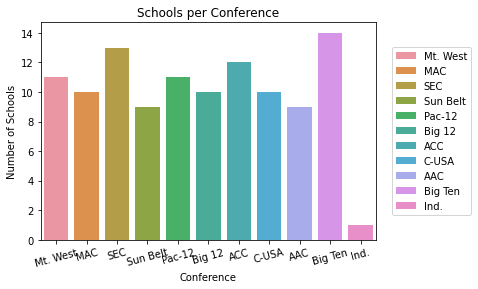

In [62]:
# Number of schools per conference. 
sns.countplot(x='Conference', data=df_final, hue='Conference', dodge=False)
_ = plt.xlabel('Conference')
_ = plt.ylabel('Number of Schools')
_ = plt.title('Schools per Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xticks(rotation=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



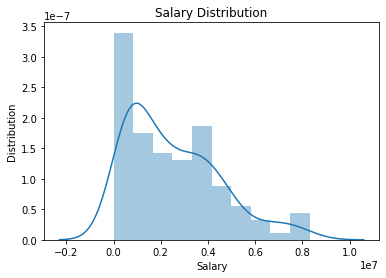

In [66]:
# Total Pay Distribution.
# We'll plot a histogram to gauge whether TotalPay follows a normal distribution or is skewed. 
sns.distplot(df_final.TotalPay, bins = 10)
_ = plt.title('Salary Distribution')
_ = plt.xlabel('Salary')
_ = plt.ylabel('Distribution')
plt.show()

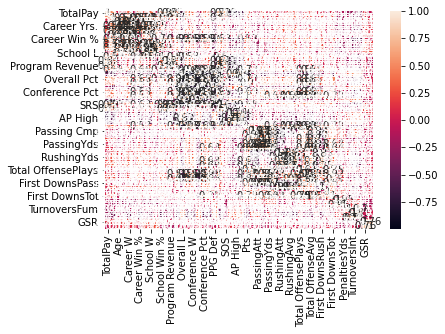

In [67]:
corrMatrix = df_final.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [68]:
#df_final['Conference2'] =df_final['Conference'].astype('category').cat.codes
df_final = pd.get_dummies(df_final, prefix='', prefix_sep='', 
                            columns=['Conference'])

In [69]:
corr_matrix = df_final.corr()
print(corr_matrix["TotalPay"].sort_values(ascending=False))

TotalPay           1.000000
Program Revenue    0.847675
Capacity           0.836794
SOS                0.761419
SRS                0.722728
                     ...   
Overall L         -0.429875
PPG Def           -0.435971
AP Rank           -0.550661
AP Pre            -0.673070
AP High           -0.691590
Name: TotalPay, Length: 61, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4af06e410>,
      dtype=object)

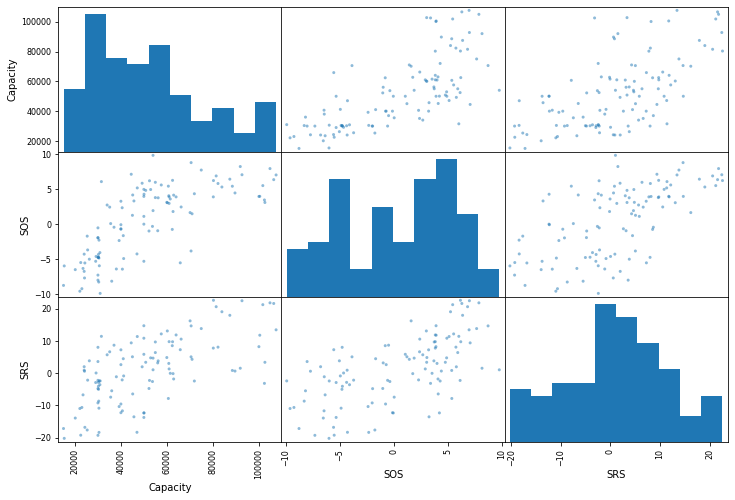

In [70]:
# make sure to specify some features that you might want to focus on or the plots might be too big
#!pip install pandas.tools
from pandas.plotting import scatter_matrix
attributes = ["Capacity","SOS","SRS"]
scatter_matrix(df_final[attributes], figsize=(12, 8))

# Modeling

## Model 1: Bring the Noise (Everything)

1.   All variables
2.   Nonsense (multicollinearity)




In [175]:
df_model = df_final[df_final.columns.difference(['Coach'])]
#feature_names= df_model.loc[:, df_model.columns != 'TotalPay']
#feature_names= feature_names.loc[:, feature_names.columns != 'School']
features = df_model.columns.values.tolist()

In [176]:
features.remove('TotalPay')
features.remove('School')
features.remove('State')

In [177]:
# Select the feature_names variables and the target variable. This will facilitate the creation of the 
# training and testing sets. 
target_name = ['TotalPay']
#print(target_name)
# We'll now take out the validation set. 
validation = df_model[df_model['School']=='Syracuse']
df_model2 = df_model[df_model['School']!='Syracuse']
len(df_model2)

109

In [178]:
# Build training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_model2[features], df_model2[target_name], test_size=0.33, random_state=19)

In [179]:
# Builds the model
model = sm.OLS(y_train, X_train)

# Fits the model
results = model.fit()

# Model results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     16.11
Date:                Tue, 20 Jul 2021   Prob (F-statistic):           3.04e-07
Time:                        01:24:58   Log-Likelihood:                -1008.8
No. Observations:                  73   AIC:                             2134.
Df Residuals:                      15   BIC:                             2266.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AAC                 1.182e+07   1.64

Model 1 R-squared:  -0.8836694444714519
Model 1 RMSE:  2791587.0026187385
Model 1 MAE:  1933263.490373585


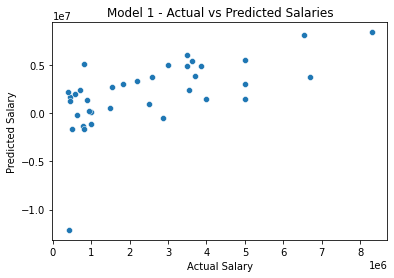

In [180]:
# Predict salaries for first model
prediction = results.predict(X_test)
prediction = pd.Series(prediction)

prediction_results = pd.concat([y_test, prediction], axis=1, ignore_index=False)
prediction_results.columns = ['TotalPay Actual', 'TotalPay Predicted']

print('Model 1 R-squared: ', r2_score(prediction_results['TotalPay Actual'], 
                                      prediction_results['TotalPay Predicted']))
print('Model 1 RMSE: ', np.sqrt(mean_squared_error(prediction_results['TotalPay Actual'], 
                                                   prediction_results['TotalPay Predicted'])))
print('Model 1 MAE: ', mean_absolute_error(prediction_results['TotalPay Actual'], 
                                           prediction_results['TotalPay Predicted']))
sns.scatterplot(x='TotalPay Actual', y='TotalPay Predicted', data=prediction_results)
_ = plt.title('Model 1 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

## Model 2 Top Correlations Only

In [181]:
features2 = ['Capacity','SOS','SRS','Bowl W','School Win %','Program Revenue']
# Build training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_model2[features2], df_model2[target_name], 
                                                   test_size=0.33, random_state=19)

In [182]:
# Builds the model
model2 = sm.OLS(y_train2, X_train2)

# Fits the model
results2 = model2.fit()

# Model results
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:               TotalPay   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              201.7
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                    7.16e-41
Time:                        01:24:59   Log-Likelihood:                         -1088.7
No. Observations:                  73   AIC:                                      2189.
Df Residuals:                      67   BIC:                                      2203.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Model 2 R-squared:  0.8123601101462734
Model 2 RMSE:  881072.0121053088
Model 2 MAE:  710496.8217966051


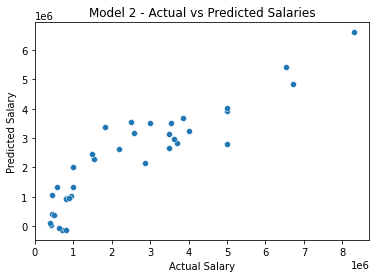

In [183]:
# Predict salaries for second model
prediction2 = results2.predict(X_test2)
prediction2 = pd.Series(prediction2)

prediction_results2 = pd.concat([y_test2, prediction2], axis=1, ignore_index=False)
prediction_results2.columns = ['TotalPay Actual', 'TotalPay Predicted']

print('Model 2 R-squared: ', r2_score(prediction_results2['TotalPay Actual'], 
                                      prediction_results2['TotalPay Predicted']))
print('Model 2 RMSE: ', np.sqrt(mean_squared_error(prediction_results2['TotalPay Actual'], 
                                                   prediction_results2['TotalPay Predicted'])))
print('Model 2 MAE: ', mean_absolute_error(prediction_results2['TotalPay Actual'], 
                                           prediction_results2['TotalPay Predicted']))
sns.scatterplot(x='TotalPay Actual', y='TotalPay Predicted', data=prediction_results2)
_ = plt.title('Model 2 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

## Model 3 Remove Noise More Variables (super over fit)

In [184]:
features.remove('TurnoversFum')
features.remove('TurnoversInt')
features.remove('First DownsPass')
features.remove('First DownsPen')
features.remove('First DownsRush')
features.remove('Career Win %')
features.remove('PassingTD')
features.remove('School L')
features.remove('School W')
features.remove('School Yrs.')
features.remove('Bowl W')
features.remove('Career L')
features.remove('Conference L')
features.remove('Total OffenseAvg')
features.remove('Overall L')
features.remove('First DownsTot')
features.remove('AAC')
features.remove('ACC')
features.remove('Big 12')
features.remove('Big Ten')
features.remove('Mt. West')
features.remove('Ind.')
features.remove('SOS')


In [185]:
# Build training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_model2[features], df_model2[target_name], test_size=0.33, random_state=19)

In [186]:
# Builds the model
model3 = sm.OLS(y_train3, X_train3)

# Fits the model
results3 = model3.fit()

# Model results
print(results3.summary())

                                 OLS Regression Results                                
Dep. Variable:               TotalPay   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              91.48
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                    3.67e-27
Time:                        01:24:59   Log-Likelihood:                         -1032.0
No. Observations:                  73   AIC:                                      2136.
Df Residuals:                      37   BIC:                                      2219.
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

Model 3 R-squared:  0.5074455189178158
Model 3 RMSE:  1427499.478795122
Model 3 MAE:  1118358.02314916


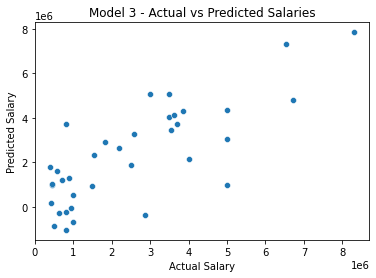

In [187]:
# Predict salaries for second model
prediction3 = results3.predict(X_test3)
prediction2 = pd.Series(prediction3)

prediction_results3 = pd.concat([y_test3, prediction3], axis=1, ignore_index=False)
prediction_results3.columns = ['TotalPay Actual', 'TotalPay Predicted']

print('Model 3 R-squared: ', r2_score(prediction_results3['TotalPay Actual'], 
                                      prediction_results3['TotalPay Predicted']))
print('Model 3 RMSE: ', np.sqrt(mean_squared_error(prediction_results3['TotalPay Actual'], 
                                                   prediction_results3['TotalPay Predicted'])))
print('Model 3 MAE: ', mean_absolute_error(prediction_results3['TotalPay Actual'], 
                                           prediction_results3['TotalPay Predicted']))
sns.scatterplot(x='TotalPay Actual', y='TotalPay Predicted', data=prediction_results3)
_ = plt.title('Model 3 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

## PCA

*   Explored but more work can be done




In [188]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = df_model2.loc[:, features].values
# Separating out the target
y = df_model2.loc[:,target_name].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

# Standardizing the target
y = StandardScaler().fit_transform(y)
print(len(y))

109


In [189]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
print(principalDf)
print(df_model2[['TotalPay']])

     principal component 1  principal component 2  principal component 3
0                 0.429728               5.766268              -2.701460
1                -1.399567               0.875860               0.115216
2                 8.312512               3.076437               2.856683
3                 1.461249               0.154127              -2.942658
4                 2.858821               1.954472              -3.241067
..                     ...                    ...                    ...
104               0.755434              -2.608136               0.029408
105              -3.014480              -4.963857              -0.144619
106              -0.215453               1.506047              -2.457924
107               6.017009               1.288361               1.646814
108              -2.200555               1.951922               2.286967

[109 rows x 3 columns]
      TotalPay
0     885000.0
1     412500.0
2    8307000.0
4     712500.0
5    2000000.0
..        

In [190]:
principalDf[["y"]] = y
finalDf = principalDf
finalDf.isnull().sum()
print(finalDf)

     principal component 1  ...         y
0                 0.429728  ... -0.837461
1                -1.399567  ... -1.079175
2                 8.312512  ...  2.959356
3                 1.461249  ... -0.925706
4                 2.858821  ... -0.267069
..                     ...  ...       ...
104               0.755434  ...  0.560383
105              -3.014480  ... -0.877952
106              -0.215453  ... -0.880944
107               6.017009  ...  0.628165
108              -2.200555  ... -0.567868

[109 rows x 4 columns]


In [191]:
#finalDf = pd.concat([principalDf, df_model2[['TotalPay']]], axis = 1)
#print(finalDf.tail())
#finalDf.isnull().sum()

In [192]:
featuresPCA = ['principal component 1', 'principal component 2','principal component 3']
# Build training and testing sets
X_trainPCA, X_testPCA, y_trainPCA, y_testPCA = train_test_split(finalDf[featuresPCA], finalDf["y"], 
                                                   test_size=0.33, random_state=19)

In [193]:
# Builds the model
modelPCA = sm.OLS(y_trainPCA, X_trainPCA)

# Fits the model
resultsPCA = modelPCA.fit()

# Model results
print(resultsPCA.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.728
Model:                            OLS   Adj. R-squared (uncentered):              0.717
Method:                 Least Squares   F-statistic:                              62.52
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                    9.14e-20
Time:                        01:24:59   Log-Likelihood:                         -54.514
No. Observations:                  73   AIC:                                      115.0
Df Residuals:                      70   BIC:                                      121.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

## Predict Syracuse Salary

In [194]:
validation

,AAC,ACC,AP High,AP Pre,AP Rank,Age,Big 12,Big Ten,Bowl W,C-USA,Capacity,Career L,Career W,Career Win %,Career Yrs.,Conference L,Conference Pct,Conference W,FGR,First DownsPass,First DownsPen,First DownsRush,First DownsTot,GSR,Ind.,MAC,Mt. West,Overall L,Overall Pct,Overall W,PPG Def,PPG Off,Pac-12,Passing Cmp,PassingAtt,PassingPct,PassingTD,PassingYds,PenaltiesNo.,PenaltiesYds,Program Revenue,Pts,RushingAtt,RushingAvg,RushingTD,RushingYds,SEC,SOS,SRS,School,School L,School W,School Win %,School Yrs.,State,Sun Belt,Total OffenseAvg,Total OffensePlays,Total OffenseYds,TotalPay,TurnoversFum,TurnoversInt,TurnoversTot
102,0,1,50.0,50.0,50.0,59,0,0,2.0,0,49250.0,51,61,0.54,9,6.0,0.25,2.0,78.0,13.1,2.3,9.0,24.4,88.0,0,0,0,8.0,0.333,4.0,32.2,27.4,0,26.7,45.7,58.4,1.7,294.8,6.2,49.4,43813014.0,27.4,39.9,4.0,1.3,161.5,0,5.8,1.96,Syracuse,36,24,0.4,5,NY,0,5.3,85.6,456.3,2401206.0,0.7,1.3,2.0


In [195]:
valid_predict = results2.predict(validation[features2])
print(valid_predict-validation['TotalPay'])
# Print results 
print('Actual Salary: ', validation['TotalPay'])
print('Model Prediction: %s' % np.round(valid_predict, 0))
print('Difference: %s' % np.round(valid_predict-validation['TotalPay']))

102   -211140.018485
dtype: float64
Actual Salary:  102    2401206.0
Name: TotalPay, dtype: float64
Model Prediction: 102    2190066.0
dtype: float64
Difference: 102   -211140.0
dtype: float64


## Fit a hierarchical model based on conference

*   Model 2 features add signifiacnt value




In [196]:
featuresConf = ['AAC','ACC','C-USA','MAC','Ind.','Mt. West','Pac-12','SEC','Sun Belt']
# Build training and testing sets
X_trainConf, X_testConf, y_trainConf, y_testConf = train_test_split(df_model2[featuresConf], df_model2[target_name], 
                                                   test_size=0.33, random_state=19)
# Builds the model
modelConf = sm.OLS(y_trainConf, X_trainConf)

# Fits the model
resultsConf = modelConf.fit()

# Model results
print(resultsConf.summary())

                                 OLS Regression Results                                
Dep. Variable:               TotalPay   R-squared (uncentered):                   0.467
Model:                            OLS   Adj. R-squared (uncentered):              0.401
Method:                 Least Squares   F-statistic:                              7.106
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                    1.04e-06
Time:                        01:24:59   Log-Likelihood:                         -1173.3
No. Observations:                  73   AIC:                                      2363.
Df Residuals:                      65   BIC:                                      2381.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning:

invalid value encountered in true_divide



In [197]:
featuresConf2 = ['Capacity','SOS','SRS','Bowl W','School Win %','Program Revenue','AAC','ACC','C-USA','MAC','Ind.','Mt. West','Pac-12','SEC','Sun Belt']
# Build training and testing sets
X_trainConf2, X_testConf2, y_trainConf2, y_testConf2 = train_test_split(df_model2[featuresConf2], df_model2[target_name], 
                                                   test_size=0.33, random_state=19)
# Builds the model
modelConf2 = sm.OLS(y_trainConf2, X_trainConf2)

# Fits the model
resultsConf2 = modelConf2.fit()

# Model results
print(resultsConf2.summary())

                                 OLS Regression Results                                
Dep. Variable:               TotalPay   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              83.81
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                    1.55e-33
Time:                        01:24:59   Log-Likelihood:                         -1085.4
No. Observations:                  73   AIC:                                      2199.
Df Residuals:                      59   BIC:                                      2231.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [198]:
from statsmodels.stats.anova import anova_lm
anova_lm(resultsConf,resultsConf2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,65.0,3.907523e+14,0.0,NaN,NaN,NaN
1,59.0,3.506829e+13,6.0,3.556840e+14,99.735659,5.207145e-29


## What would his salary be if we were still in the Big East? What if we went to the Big Ten?

*   Big East would not factor into this model as it is not included in the originial dataset
*   Replacing ACC 'Yes' with Big Ten 'Yes'

Pay-cut would be needed :)



In [199]:
validation.at[102, 'ACC'] = 0
validation.at[102, 'Big Ten'] = 1

In [200]:
validation

,AAC,ACC,AP High,AP Pre,AP Rank,Age,Big 12,Big Ten,Bowl W,C-USA,Capacity,Career L,Career W,Career Win %,Career Yrs.,Conference L,Conference Pct,Conference W,FGR,First DownsPass,First DownsPen,First DownsRush,First DownsTot,GSR,Ind.,MAC,Mt. West,Overall L,Overall Pct,Overall W,PPG Def,PPG Off,Pac-12,Passing Cmp,PassingAtt,PassingPct,PassingTD,PassingYds,PenaltiesNo.,PenaltiesYds,Program Revenue,Pts,RushingAtt,RushingAvg,RushingTD,RushingYds,SEC,SOS,SRS,School,School L,School W,School Win %,School Yrs.,State,Sun Belt,Total OffenseAvg,Total OffensePlays,Total OffenseYds,TotalPay,TurnoversFum,TurnoversInt,TurnoversTot
102,0,0,50.0,50.0,50.0,59,0,1,2.0,0,49250.0,51,61,0.54,9,6.0,0.25,2.0,78.0,13.1,2.3,9.0,24.4,88.0,0,0,0,8.0,0.333,4.0,32.2,27.4,0,26.7,45.7,58.4,1.7,294.8,6.2,49.4,43813014.0,27.4,39.9,4.0,1.3,161.5,0,5.8,1.96,Syracuse,36,24,0.4,5,NY,0,5.3,85.6,456.3,2401206.0,0.7,1.3,2.0


In [201]:
valid_predict_Big10 = resultsConf2.predict(validation[featuresConf2])
print(valid_predict-validation['TotalPay'])
# Print results 
print('Actual Salary: ', validation['TotalPay'])
print('Model Prediction: %s' % np.round(valid_predict_Big10, 0))
print('Difference if Big 10: %s' % np.round(valid_predict_Big10-valid_predict))

102   -211140.018485
dtype: float64
Actual Salary:  102    2401206.0
Name: TotalPay, dtype: float64
Model Prediction: 102    2167572.0
dtype: float64
Difference if Big 10: 102   -22494.0
dtype: float64


# What schools did we drop from our data and why?

*   The following 19 schools were dropped due to many missing values (including key features)




In [202]:
dropped=df_6[df_6.isna().any(axis=1)]
dropped

,TotalPay,Conference,Coach,Bowl W,School,Age,Career Yrs.,Career W,Career L,Career Win %,School Yrs.,School W,School L,School Win %,Capacity,Program Revenue,Overall W,Overall L,Overall Pct,Conference W,Conference L,Conference Pct,PPG Off,PPG Def,SRS,SOS,AP Pre,AP High,AP Rank,Pts,Passing Cmp,PassingAtt,PassingPct,PassingYds,PassingTD,RushingAtt,RushingYds,RushingAvg,RushingTD,Total OffensePlays,Total OffenseYds,Total OffenseAvg,First DownsPass,First DownsRush,First DownsPen,First DownsTot,PenaltiesNo.,PenaltiesYds,TurnoversFum,TurnoversInt,TurnoversTot,State,GSR,FGR
3,900000.0,C-USA,Bill Clark,0.0,Alabama at Birmingham,52,6,49,26,0.653000,5,38,22,0.633000,71594.0,36494381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,73.000000,47.000
9,932521.0,Ind.,Jeff Monken,3.0,Army,53,11,85,54,0.612000,7,47,38,0.553000,38000.0,25000000.0,10.0,3.0,0.769,NaN,NaN,NaN,30.7,22.0,3.69,-3.00,50.0,50.0,50.0,30.7,1.5,5.0,30.8,27.8,0.2,60.4,362.3,6.0,3.8,65.4,390.1,6.0,1.2,18.5,1.0,20.8,4.2,36.3,0.4,0.5,0.8,NY,80.181102,62.904
15,437228.0,MAC,Mike Jinks,0.0,Bowling Green,49,3,7,24,0.225806,3,7,24,0.225806,23724.0,26001184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OH,78.000000,68.000
16,0.0,Ind.,Kalani Sitake,3.0,Brigham Young,45,5,36,26,0.580000,5,36,26,0.580000,63725.0,23171603.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,17.1,17.5,32.2,54.5,194.6,1.0,30.9,130.7,4.2,0.9,63.1,325.3,5.2,8.9,6.7,0.9,16.5,4.5,39.2,0.6,1.5,2.1,UT,70.000000,40.000
19,1700000.0,AAC,Josh Heupel,0.0,Central Florida,42,3,28,7,0.800000,3,28,7,0.800000,45323.0,69121887.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,81.000000,65.000
50,947281.0,Ind.,Turner Gill,0.0,Liberty,58,12,72,84,0.461538,7,47,35,0.573171,25000.0,16358467.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VA,65.000000,55.000
52,850000.0,Sun Belt,Billy Napier,2.0,Louisiana-Lafayette,41,3,27,11,0.711000,3,27,11,0.711000,31000.0,32544966.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA,85.000000,68.000
58,500000.0,Ind.,Mark Whipple,0.0,Massachusetts,64,21,137,103,0.570833,11,65,70,0.481481,17000.0,49461013.0,4.0,8.0,0.333,NaN,NaN,NaN,30.6,31.8,-9.36,-7.03,50.0,50.0,50.0,30.6,22.7,37.3,60.9,297.5,2.2,34.8,135.5,3.9,1.6,72.1,433.0,6.0,12.8,6.8,2.0,21.7,6.6,56.6,0.9,0.5,1.4,MA,67.000000,51.000
60,4058061.0,ACC,Mark Richt,10.0,University of Miami (Florida),61,18,171,64,0.727660,3,26,13,0.666667,65326.0,30000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,76.000000,42.000
61,524826.0,MAC,Chuck Martin,0.0,Miami (Ohio),52,13,106,53,0.667000,7,32,46,0.410000,24286.0,39644248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OH,89.000000,72.000


In [203]:
print(dropped["School"])
print(len(dropped["School"]))

3                   Alabama at Birmingham
9                                    Army
15                          Bowling Green
16                          Brigham Young
19                        Central Florida
50                                Liberty
52                    Louisiana-Lafayette
58                          Massachusetts
60          University of Miami (Florida)
61                           Miami (Ohio)
64                       Middle Tennessee
66                            Mississippi
72                       Nevada-Las Vegas
80                             Notre Dame
89                             Pittsburgh
98                    Southern California
99                     Southern Methodist
109                         Texas-El Paso
110    University of Texas at San Antonio
Name: School, dtype: object
19


# What effect does graduation rate have on the projected salary?

*   Not much... weak correlations (GSR slightly positive)
*   Do not add incremental predictive validity above more prominent features



In [204]:
df_final["TotalPay"].corr(df_final["GSR"])

0.12974907644966235

In [205]:
df_final["TotalPay"].corr(df_final["FGR"])

-0.03585670078919374

# How good is our model?

*   Pretty solid with room for growth (more features, more complex models)
*   Some overfitting (0.94 Adj. R sq. in training, 0.81 in test)



In [206]:
# Model results
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:               TotalPay   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              201.7
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                    7.16e-41
Time:                        01:25:00   Log-Likelihood:                         -1088.7
No. Observations:                  73   AIC:                                      2189.
Df Residuals:                      67   BIC:                                      2203.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Model 2 R-squared:  0.8123601101462734
Model 2 RMSE:  881072.0121053088
Model 2 MAE:  710496.8217966051


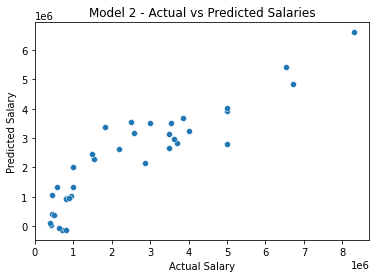

In [207]:
print('Model 2 R-squared: ', r2_score(prediction_results2['TotalPay Actual'], 
                                      prediction_results2['TotalPay Predicted']))
print('Model 2 RMSE: ', np.sqrt(mean_squared_error(prediction_results2['TotalPay Actual'], 
                                                   prediction_results2['TotalPay Predicted'])))
print('Model 2 MAE: ', mean_absolute_error(prediction_results2['TotalPay Actual'], 
                                           prediction_results2['TotalPay Predicted']))
sns.scatterplot(x='TotalPay Actual', y='TotalPay Predicted', data=prediction_results2)
_ = plt.title('Model 2 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

# What is the single biggest impact on salary size?

1.   Stadardized data
2.   Program Revenue is the most important to the model (which makes sense)



In [208]:
# standardizing dataframe
from scipy import stats
import statsmodels.formula.api as smf
df_z = df_model2.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)

In [209]:
features2 = ['Capacity','SOS','SRS','Bowl W','School Win %','Program Revenue']
# Build training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_z[features2], df_z[target_name], 
                                                   test_size=0.33, random_state=19)

In [210]:
# Builds the model
model2 = sm.OLS(y_train2, X_train2)

# Fits the model
results2 = model2.fit()

# Model results
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:               TotalPay   R-squared (uncentered):                   0.856
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                              66.12
Date:                Tue, 20 Jul 2021   Prob (F-statistic):                    3.23e-26
Time:                        01:25:00   Log-Likelihood:                         -31.449
No. Observations:                  73   AIC:                                      74.90
Df Residuals:                      67   BIC:                                      88.64
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Feature: 0, Score: 0.16302
Feature: 1, Score: 0.21282
Feature: 2, Score: 0.12680
Feature: 3, Score: 0.14397
Feature: 4, Score: 0.09863
Feature: 5, Score: 0.35329


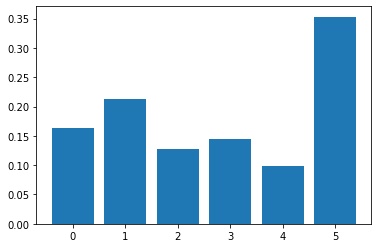

In [211]:
import matplotlib
import matplotlib.pyplot as pyplot
# get importance
importance = results2.params
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Random Forest Exploration

In [225]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=19)
rf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=19, verbose=0, warm_start=False)

In [226]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')


Out-of-bag R-2 score estimate: 0.796
Test data R-2 score: 0.732
Test data Spearman correlation: 0.874
